In [2]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
import altair as alt
from altair import datum

%run constants.py

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn, alt]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.0
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2
  altair: 4.1.0


# Problem description
We are provided with daily historical sales data (in a day by day format) and the task is to forecast the total amount of products sold in every shop for the test set, which is dated to the next month.

Evaluation will be done with RMSE. One thing caught my attention: True target values are clipped into `[0,20]`.

# But first, conventions

Let's define some conventions here. The first one is the folder structure.
- `.data/`: Where all data will reside
- `.data/01-raw/`: Raw datasets
- `.data/02-processed/`: Intermediate datasets, like generated feature sets
- `.data/03-models/`: trained models
- `.data/04-model-output/`: output from the models
- `notebooks/` (this directory): all notebooks that generated the trained models and the submissions

All this is encoded in [constants.py](./constants.py).

So let's create this structure right away.

In [3]:
%%bash
mkdir -p ../.data/01-raw
mkdir -p ../.data/02-processed
mkdir -p ../.data/03-models
mkdir -p ../.data/04-model-output

And let's download the raw dataset:

In [4]:
%%bash
kaggle competitions download -c competitive-data-science-predict-future-sales -p ../.data/01-raw

competitive-data-science-predict-future-sales.zip: Skipping, found more recently modified local copy (use --force to force download)


# Loading original dataset

In [5]:
# load all csvs
import zipfile
with zipfile.ZipFile(os.path.join(RAW_DATA_DIR, 'competitive-data-science-predict-future-sales.zip'), 'r') as datasets_file:
    item_categories = pd.read_csv(datasets_file.open('item_categories.csv'))
    items = pd.read_csv(datasets_file.open('items.csv'))
    sales_train = pd.read_csv(datasets_file.open('sales_train.csv'))
    sample_submission = pd.read_csv(datasets_file.open('sample_submission.csv'))
    shops = pd.read_csv(datasets_file.open('shops.csv'))
    test_set = pd.read_csv(datasets_file.open('test.csv'))

# Training/test sets

In [6]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [7]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
test_set.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


In [9]:
test_set.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


First thing I noticed by looking at the descriptions: shop ids below 2 were dropped on the test set, along with item ids below 30. Let's filter those lines out from the train set right away.

In [10]:
sales_train_filtered = sales_train[~((sales_train['shop_id'] < 2) | (sales_train['item_id'] < 30) | (sales_train['item_id'] > 22167))]

In [11]:
sales_train_filtered.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.920132e+06,2.920132e+06,2.920132e+06,2.920132e+06,2.920132e+06
mean,1.464506e+01,3.317534e+01,1.019529e+04,8.926938e+02,1.243099e+00
std,9.391895e+00,1.609398e+01,6.324212e+03,1.731929e+03,2.625509e+00
min,0.000000e+00,2.000000e+00,3.000000e+01,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.475000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.327000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568300e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216700e+04,3.079800e+05,2.169000e+03


That reduces a bit the data set, which should be good for us.

The next thing I noticed is the train data has prices for each item sold, while test doesn't. This means we'll probably have to rely on previous month's prices instead of the current ones.

About the clipping on the true targets range: let's see if this also happens on the train set.

In [12]:
# notice `date_block_num` is actually related to the month
sales_train_by_month = sales_train_filtered.groupby(by=['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
sales_train_by_month.rename(columns={'item_cnt_day': 'item_cnt'}, inplace=True)
sales_train_by_month['item_cnt'].describe()

count    1.600855e+06
mean     2.267546e+00
std      8.668920e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
Name: item_cnt, dtype: float64

Nope :) Just have to remember to clip the train target. Also interesting to see that the 75 percentile is 2 while the maximum is 2,253. As the distribution is so skewed to 0, let's try plotting it in a log scale and se what happens:

<AxesSubplot:>

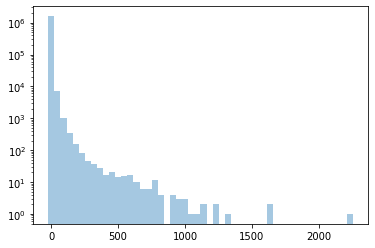

In [13]:
sns.distplot(sales_train_by_month['item_cnt'].values, hist_kws={'log':True}, kde=False, norm_hist=False)

Results near zero are orders of magnitude larger than the rest, but let's keep in mind this is before the clipping. Let's clip it and see how this looks like

In [14]:
sales_train_by_month_clipped = sales_train_by_month.copy()
sales_train_by_month_clipped['item_cnt'] = np.clip(sales_train_by_month_clipped['item_cnt'], 0, 20)
sales_train_by_month_clipped.describe()

,date_block_num,shop_id,item_id,item_cnt
count,1.600855e+06,1.600855e+06,1.600855e+06,1.600855e+06
mean,1.473702e+01,3.296987e+01,1.067828e+04,2.022226e+00
std,9.513026e+00,1.641684e+01,6.238855e+03,2.577318e+00
min,0.000000e+00,2.000000e+00,3.000000e+01,0.000000e+00
25%,6.000000e+00,2.100000e+01,5.043000e+03,1.000000e+00
50%,1.400000e+01,3.100000e+01,1.049200e+04,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.605900e+04,2.000000e+00
max,3.300000e+01,5.900000e+01,2.216700e+04,2.000000e+01


<AxesSubplot:>

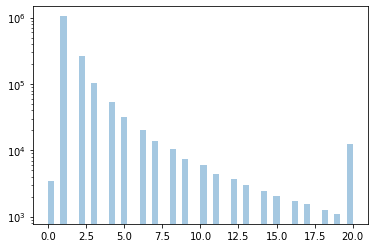

In [15]:
sns.distplot(sales_train_by_month_clipped['item_cnt'].values, hist_kws={'log':True}, kde=False, norm_hist=False)

Still not pretty, decaying orders of magnitude until it reaches 20. Good to keep that in mind (maybe we're better off predicting only the extremities well?). Either way, let's save this and move on to how train and test compares.

In [17]:
sales_train_by_month_clipped.to_parquet(os.path.join(PROCESSED_DATA_DIR, 'sales_train_by_month.parquet'))

# Train/Test consistency

We need to generate the train set from a list of historical events. The problem with that is we may end up with a train set that doesn't come from the same probability distribution as the test set samples.

To test this, let's look at the distribution of item id + shop id pairs on each data set. For that we'll plot a 2D histogram on each dataset:

In [ ]:
sns.jointplot(data=sales_train_by_month_clipped, x='shop_id', y='item_id', kind='kde')

In [ ]:
sns.jointplot(data=test_set, x='shop_id', y='item_id', kind='kde')

Yep. They look nothing alike. Maybe the dataset distribution is not temporally consistent, so let's try plotting the training set with the last month only.

In [ ]:
sales_train_last_month = sales_train_by_month_clipped[sales_train_by_month_clipped['date_block_num'] == sales_train_by_month_clipped['date_block_num'].max()]
sales_train_last_month.describe()

In [ ]:
sns.jointplot(data=sales_train_last_month, x='shop_id', y='item_id', kind='kde')

Still completely different. We can double-check this by training an algorithm to discriminate between test and training set and see how well it does. We'll limit the training set to the last month so we have a more recent data.

In [ ]:
# first let's prepare a dataset
discr_dataset_a = test_set[['shop_id', 'item_id']].drop_duplicates()
discr_dataset_a['target'] = 1

discr_dataset_b = sales_train_last_month[['shop_id', 'item_id']].drop_duplicates()
discr_dataset_b['target'] = 0

discr_dataset = pd.concat([discr_dataset_a, discr_dataset_b], axis=0)
discr_dataset.describe()

Since it's very skewed, let's use a gradient boosted tree that deals with this pretty well. I won't tune this since we just want to know if it's possible to differentiate both datasets.

In [66]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    discr_dataset[['shop_id', 'item_id']].values, discr_dataset['target'].values, 
    test_size=0.33, random_state=42)
discr = XGBClassifier(n_jobs=-1)
discr.fit(X_train, y_train)
y_test_pred = discr.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_test_pred)

0.7614468990148078

That's a pretty good score for a random classifier, which adds to our suspicion that the train and test datasets don't come from the same distribution. 

I thought of two ways of solving it: use the test set ids as the training set; or set to zero the prediction for all shop/item pairs on test set that are not present on our training set. While the first option would be better for real-life (replicating the distribution from the test set on the training set), we will take advantage of this leak here since it's a competition.

Let's check how much these two sets intersect:

In [67]:
pd.merge(sales_train_last_month, test_set, on=['item_id', 'shop_id']).describe()

,date_block_num,shop_id,item_id,item_cnt,ID
count,28680.0,28680.000000,28680.000000,28680.000000,28680.000000
mean,33.0,31.995223,10701.266213,1.909344,97945.114052
std,0.0,16.488541,6102.659012,2.390357,57375.678071
min,33.0,2.000000,30.000000,0.000000,2.000000
25%,33.0,19.000000,5005.000000,1.000000,49482.000000
50%,33.0,31.000000,10659.000000,1.000000,93239.000000
75%,33.0,46.000000,15494.000000,2.000000,141858.500000
max,33.0,59.000000,22167.000000,20.000000,214195.000000


It's a big intersection: almost all (~91%) of the samples on the last month are present on the test set.

# Benchmark submission

The sample submission uses the counts for the last month, and imputs the missing values with zero.

In [73]:
solution_benchmark = pd.merge(sales_train_last_month, test_set, how='right', on=['item_id', 'shop_id']).fillna(0)
solution_benchmark.describe()

,date_block_num,shop_id,item_id,item_cnt,ID
count,214200.000000,214200.000000,214200.000000,214200.000000,214200.000000
mean,4.418487,31.642857,11019.398627,0.255649,107099.500000
std,11.237777,17.561933,6252.644590,1.089856,61834.358168
min,0.000000,2.000000,30.000000,0.000000,0.000000
25%,0.000000,16.000000,5381.500000,0.000000,53549.750000
50%,0.000000,34.500000,11203.000000,0.000000,107099.500000
75%,0.000000,47.000000,16071.500000,0.000000,160649.250000
max,33.000000,59.000000,22167.000000,20.000000,214199.000000


In [77]:
solution_benchmark[["ID", "item_cnt"]].rename(columns={"item_cnt": "item_cnt_month"}).to_csv(os.path.join(SUBMISSIONS_DIR, 'benchmark_submission.csv'), index=False)

The score is as expected: 1.16777. Let's try and beat that with some simple heuristics. Instead of replacing NaNs with zeros, let's replace them with the mean of the other items counts.

In [87]:
benchmark_mean_imputation = pd.merge(sales_train_last_month, test_set, how='right', on=['item_id', 'shop_id'])
benchmark_mean_imputation.fillna(benchmark_mean_imputation['item_cnt'].mean(), inplace=True)
benchmark_mean_imputation.describe()

,date_block_num,shop_id,item_id,item_cnt,ID
count,214200.000000,214200.000000,214200.000000,214200.000000,214200.000000
mean,6.072183,31.642857,11019.398627,1.909344,107099.500000
std,10.587572,17.561933,6252.644590,0.874654,61834.358168
min,1.909344,2.000000,30.000000,0.000000,0.000000
25%,1.909344,16.000000,5381.500000,1.909344,53549.750000
50%,1.909344,34.500000,11203.000000,1.909344,107099.500000
75%,1.909344,47.000000,16071.500000,1.909344,160649.250000
max,33.000000,59.000000,22167.000000,20.000000,214199.000000


In [88]:
benchmark_mean_imputation[["ID", "item_cnt"]].rename(columns={"item_cnt": "item_cnt_month"}).to_csv(os.path.join(SUBMISSIONS_DIR, 'benchmark_mean_imputation.csv'), index=False)

Surprise surprise: `1.99060`. Even though the mean was relatively low (~1.909). Let's try with the median.

In [89]:
benchmark_median_imputation = pd.merge(sales_train_last_month, test_set, how='right', on=['item_id', 'shop_id'])
benchmark_median_imputation.fillna(benchmark_median_imputation['item_cnt'].median(), inplace=True)
benchmark_median_imputation.describe()

,date_block_num,shop_id,item_id,item_cnt,ID
count,214200.000000,214200.000000,214200.000000,214200.000000,214200.000000
mean,5.284594,31.642857,11019.398627,1.121755,107099.500000
std,10.897239,17.561933,6252.644590,0.927854,61834.358168
min,1.000000,2.000000,30.000000,0.000000,0.000000
25%,1.000000,16.000000,5381.500000,1.000000,53549.750000
50%,1.000000,34.500000,11203.000000,1.000000,107099.500000
75%,1.000000,47.000000,16071.500000,1.000000,160649.250000
max,33.000000,59.000000,22167.000000,20.000000,214199.000000


In [90]:
benchmark_median_imputation[["ID", "item_cnt"]].rename(columns={"item_cnt": "item_cnt_month"}).to_csv(os.path.join(SUBMISSIONS_DIR, 'benchmark_median_imputation.csv'), index=False)

Better than before: `1.39120`. Still worse than zero-imputation. I guess it's safe to assume everything that wasn't seen before to be zero and move on, at least for now.

# Conclusion

The work on this notebook was focused mainly on validating our more fundamental assumptions, the main one being the difference between the distribution that generated the train set and the distribution that generated the test set.